In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('test.csv', sep='|')

/home/jmckenzie/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#strip whitespace from the bet_type column and then remove the asian handicap bets
def remove_whitespace(entry):
    return entry.strip(' ')

#convert odds to probabilities remove the overound and create own overound
def odds_to_probs(odds):
    return 1.0 / odds

#function to calculate expected goals from the probabilities and the handicap value
from scipy.optimize import minimize_scalar
import math
import numpy as np
from scipy.stats import distributions

#make functions
def expected_goal_num(num, probability):
    'Takes the under number and probability from bookies prices and calculates expected number of goals'
    num = int(num - 0.5)
    def func_to_min(x):
        return (distributions.poisson.cdf(num, x) - probability)**2
    return minimize_scalar(func_to_min, method='Golden')['x']

#find discrepancies between betting lines and create new dataframe with discrepancy information
def get_discrepancies(df):
    discrepancies = []
    for home_team in df['home_team'].unique():
        for away_team in df['away_team'].unique():
            game_series = df[(df['home_team'] ==  home_team) & (df['away_team'] ==  away_team)]
            for i in game_series['goals_under_mod']:
                prob2_mod = float(game_series.loc[game_series['goals_under_mod'] ==  i].prob2_mod)
                handicap_under = float(game_series.loc[game_series['goals_under_mod'] == i].handicap)
                home_goals = game_series.home_full_time_goals.values[0]
                away_goals = game_series.away_full_time_goals.values[0]
                for j in game_series['goals_over_mod']:
                    prob1_mod = float(game_series.loc[game_series['goals_over_mod'] ==  j].prob1_mod)
                    handicap_over = float(game_series.loc[game_series['goals_over_mod'] == j].handicap)
                    if i > j:
                        discrepancies.append([home_team.strip(' '), away_team.strip(' '),
                                              home_goals, away_goals,
                                              handicap_under, handicap_over, 
                                              i, j, prob2_mod, prob1_mod])
    return pd.DataFrame(discrepancies, columns=['home_team', 'away_team', 'home_goals', 'away_goals', 'handicap_under', 'handicap_over','expected_goals_under',
                                               'expected_goals_over', 'probability_under', 'probability_over'])

#get expected value
def get_expected_under(handicap, expected_goals_over, probability_under):
    return distributions.poisson.cdf(handicap - 0.5, expected_goals_over) * (1.0 / probability_under) - 1

def get_expected_over(handicap, expected_goals_under, probability_over):
    return (1 - distributions.poisson.cdf(handicap - 0.5, expected_goals_under)) * (1.0 / probability_over) - 1

#get winnings per stake
def get_winnings(stake, price, win_col):
    return stake*((price*win_col) - 1)

In [96]:
#strip whitespace for the column headers, just keep relevent columns
data.columns = [i.strip(' ') for i in data.columns]

to_keep = ['bet_type', 'handicap', 'price1', 'price2', 'price3', 'home_team',
          'away_team', 'match_datetime', 'home_full_time_goals', 'away_full_time_goals']

#remove white space and remove asian handicap markets
df = data[to_keep]
df = df.dropna(axis=0, subset=['bet_type'])
df['bet_type'] = df.bet_type.apply(remove_whitespace)
df = df[df.bet_type != 'AH']

#calculate overound - remove it and add my own 
df['overound'] = df.price1.apply(odds_to_probs) + df.price2.apply(odds_to_probs)
df['prob1'] = df.price1.apply(odds_to_probs)
df['prob2'] = df.price2.apply(odds_to_probs)
df['prob1_mod'] = (df['prob1'] / df['overound']) * 1.025
df['prob2_mod'] = (df['prob2'] / df['overound']) * 1.025

In [97]:
#get subset of the dataframe with 1000 rows
test_df = df.head(1000)

#apply the expected goals calculation over both actual probabiltites and modified probabilities
test_df.loc[:, 'expected_goals_over'] = test_df.apply(lambda x:
                                                      expected_goal_num(x['handicap'], 1 - x['prob1']), axis=1)
test_df.loc[:, 'expected_goals_under'] = test_df.apply(lambda x: 
                                                       expected_goal_num(x['handicap'], x['prob2']), axis=1)

test_df.loc[:, 'goals_over_mod'] = test_df.apply(lambda x: 
                                                 expected_goal_num(x['handicap'], 1 - x['prob1_mod']), axis=1)
test_df.loc[:, 'goals_under_mod'] = test_df.apply(lambda x: 
                                                  expected_goal_num(x['handicap'], x['prob2_mod']), axis=1)

#get discrepancy dataframe
discrepancies = get_discrepancies(test_df)

/home/jmckenzie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jmckenzie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [98]:
#get expected value for each over and under bet
discrepancies['expected_under_win_per_stake'] = discrepancies.apply(lambda x :
                                                             get_expected_under(x['handicap_under'],
                                                                               x['expected_goals_over'],
                                                                               x['probability_under']),
                                                             axis = 1)

discrepancies['expected_over_win_per_stake'] = discrepancies.apply(lambda x :
                                                             get_expected_over(x['handicap_over'],
                                                                               x['expected_goals_under'],
                                                                               x['probability_over']),
                                                             axis = 1)
#get total goals column
discrepancies['total_goals'] = discrepancies['home_goals'] + discrepancies['away_goals']
discrepancies['stake_under'] = 1.0 / discrepancies['expected_under_win_per_stake']
discrepancies['stake_over'] = 1.0 / discrepancies['expected_over_win_per_stake']

#get win / lose outcomes
discrepancies['win_under'] = discrepancies['handicap_under'] > discrepancies['total_goals']
discrepancies['win_over'] = discrepancies['handicap_over'] < discrepancies['total_goals']

#convert bools to ints
discrepancies['win_under'] = discrepancies['win_under'].astype(int)
discrepancies['win_over'] = discrepancies['win_over'].astype(int)

#calculate winnings based on stake
discrepancies['under_winnings'] = discrepancies.apply(lambda x: get_winnings(x['stake_under'], 
                                                                            1 / x['probability_under'],
                                                                            x['win_under']), axis = 1)

discrepancies['over_winnings'] = discrepancies.apply(lambda x: get_winnings(x['stake_over'], 
                                                                            1 / x['probability_over'],
                                                                            x['win_over']), axis = 1)
discrepancies['winnings'] = discrepancies['under_winnings'] + discrepancies['over_winnings']
discrepancies['total_stake'] = discrepancies['stake_under'] + discrepancies['stake_over']

In [100]:
discrepancies.shape

(83, 21)

In [63]:
def apply_filters(dataframe, remove_handicaps = [], expected_goal_diff = 0):
    """parameters:-
    
                remove_handicaps = list of handicaps to remove
                expected_goal_diff = float"""
    
    dataframe = dataframe.loc[(~dataframe.handicap_under.isin(remove_handicaps)) & 
                             (~dataframe.handicap_over.isin(remove_handicaps))]
    
    dataframe = dataframe[abs(dataframe['expected_goals_under'] - 
                              dataframe['expected_goals_over']) > expected_goal_diff]
    
    dataframe['rolling_sum'] = dataframe['winnings'].cumsum()
    return dataframe

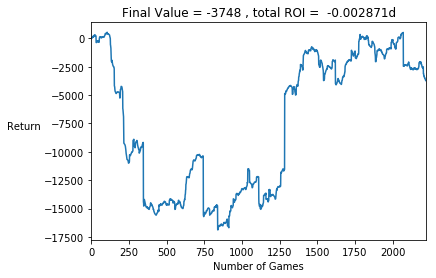

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

dataframe = apply_filters(discrepancies, remove_handicaps=[], expected_goal_diff= 0)
dataframe.reset_index(inplace=True)

dataframe['ROI'] = (dataframe['under_winnings'] / dataframe['stake_under']) + (dataframe['over_winnings'] / dataframe['stake_over'])    

ax = dataframe.rolling_sum.plot(title= 'Final Value = %d , total ROI = %10fd'
                                % (dataframe.tail(1).rolling_sum.values[0], dataframe.winnings.sum() /  dataframe.total_stake.sum()))
ax.set_xlabel('Number of Games')
ax.set_ylabel('Return', rotation = 'horizontal', labelpad= 20)

In [95]:
discrepancies.shape

(2224, 21)